Loading dataset...
Loaded 40 images with shape 10304
Splitting dataset...
Extracting features using PCA...
Classifying using PCA features...
PCA Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

     person1       1.00      1.00      1.00         1
     person2       1.00      1.00      1.00         4
     person3       1.00      1.00      1.00         2
     person4       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



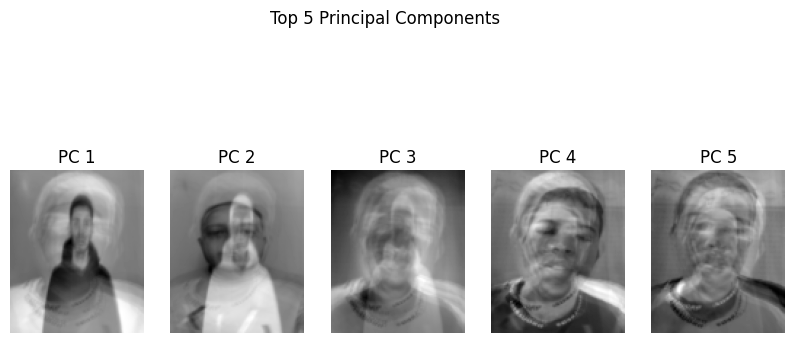

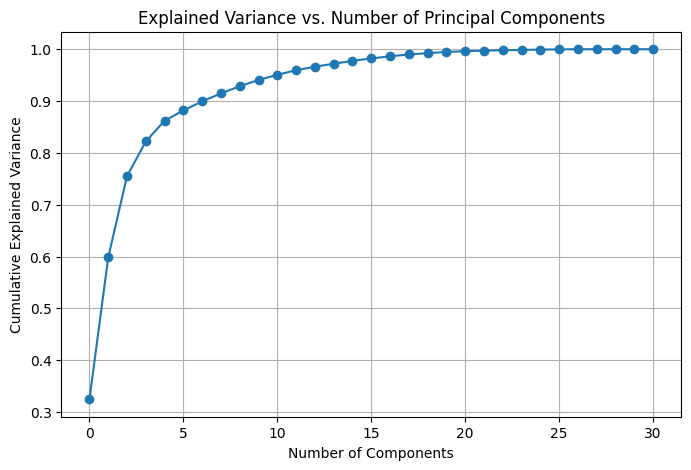

Extracting features using HOG...
Classifying using HOG features...
HOG Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

     person1       0.50      1.00      0.67         1
     person2       1.00      0.75      0.86         4
     person3       1.00      1.00      1.00         2
     person4       1.00      1.00      1.00         1

    accuracy                           0.88         8
   macro avg       0.88      0.94      0.88         8
weighted avg       0.94      0.88      0.89         8

Visualizing HOG for a sample image...


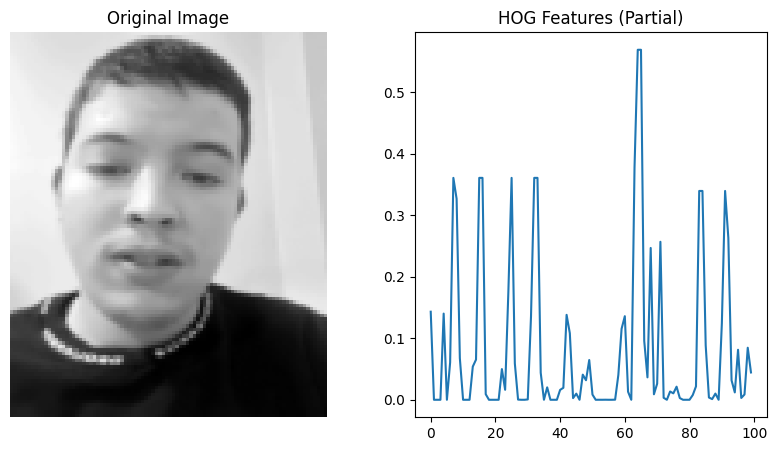

Feature Extraction Comparison:
PCA Accuracy: 1.00
HOG Accuracy: 0.88


In [4]:
import os
import numpy as np # type: ignore
from imageio.v3 import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step 1: Load Dataset 
def load_dataset(folder_path, target_shape=(112, 92)):
    data = []
    labels = []
    for person_folder in sorted(os.listdir(folder_path)):
        person_path = os.path.join(folder_path, person_folder)
        if os.path.isdir(person_path):
            for image_name in sorted(os.listdir(person_path)):
                if image_name.endswith(('.jpg', '.png', '.jpeg', '.pgm')):
                    image_path = os.path.join(person_path, image_name)
                    image = imread(image_path, mode='F')
                    image_resized = resize(image, target_shape)
                    data.append(image_resized.flatten())
                    labels.append(person_folder)
    return np.array(data), np.array(labels)

# Step 2: Feature Extraction with PCA
def extract_features_pca(data, n_components):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

# Step 3: Feature Extraction with HOG
def extract_features_hog(data, image_shape):
    hog_features = []
    for img_flat in data:
        image = img_flat.reshape(image_shape)
        features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Step 4: Classify using Nearest Neighbor
def classify_knn(train_features, train_labels, test_features, test_labels):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_features, train_labels)
    predictions = knn.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy, predictions

# Step 5: Evaluate the Model
def evaluate_model(predictions, test_labels):
    print("Classification Report:")
    print(classification_report(test_labels, predictions))

# Step 6: Visualize PCA and HOG
def visualize_pca(pca_model, image_shape):
    # Plot the first few principal components as images
    components = pca_model.components_.reshape((-1, *image_shape))
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(components[i], cmap='gray')
        plt.title(f"PC {i+1}")
        plt.axis('off')
    plt.suptitle("Top 5 Principal Components")
    plt.show()

def plot_explained_variance(pca_model):
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca_model.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance vs. Number of Principal Components")
    plt.grid()
    plt.show()
   

def visualize_hog_sample(original_image, hog_features, image_shape):
    # Reshape HOG features back into an image-like format (approximation)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.reshape(image_shape), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(hog_features[:100])  # Plot a portion of the HOG feature vector
    plt.title("HOG Features (Partial)")
    plt.show()

# Step 7: Main Program
if __name__ == "__main__":
    # Paths and Parameters
    dataset_folder = "./group_dataset"  # Replace with your dataset path
    target_shape = (112, 92)
    n_components = 31

    # Load Dataset
    print("Loading dataset...")
    data, labels = load_dataset(dataset_folder, target_shape=target_shape)
    print(f"Loaded {data.shape[0]} images with shape {data.shape[1]}")

    # Split Dataset
    print("Splitting dataset...")
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

    # PCA Feature Extraction
    print("Extracting features using PCA...")
    train_pca, pca_model = extract_features_pca(train_data, n_components=n_components)
    test_pca = pca_model.transform(test_data)

    # Classify with PCA Features
    print("Classifying using PCA features...")
    pca_accuracy, pca_predictions = classify_knn(train_pca, train_labels, test_pca, test_labels)
    print(f"PCA Accuracy: {pca_accuracy:.2f}")
    evaluate_model(pca_predictions, test_labels)

    # Visualize PCA
    visualize_pca(pca_model, target_shape)
    plot_explained_variance(pca_model)


    # HOG Feature Extraction
    print("Extracting features using HOG...")
    train_hog = extract_features_hog(train_data, target_shape)
    test_hog = extract_features_hog(test_data, target_shape)

    # Classify with HOG Features
    print("Classifying using HOG features...")
    hog_accuracy, hog_predictions = classify_knn(train_hog, train_labels, test_hog, test_labels)
    print(f"HOG Accuracy: {hog_accuracy:.2f}")
    evaluate_model(hog_predictions, test_labels)

    # Visualize a sample HOG image and its features
    print("Visualizing HOG for a sample image...")
    sample_index = 0  # Choose the first sample image
    visualize_hog_sample(train_data[sample_index], train_hog[sample_index], target_shape)

    # Compare PCA and HOG
    print("Feature Extraction Comparison:")
    print(f"PCA Accuracy: {pca_accuracy:.2f}")
    print(f"HOG Accuracy: {hog_accuracy:.2f}")
